## ASTR 596: The Midterm

#### 5 parts, 20 pts each. Some parts are easier than others, so are essentially free points, but you'll need to solve the earlier parts correctly to get the right answer on the later parts. I'd strongly recommend skimming the Riess et al. 2011 paper. 

#### We've been building up our ability to deal with complex data, and you've now got the ability to fit straight lines with frequentist tools (as you did with the Cepheids), and infer constraints on more complex high-dimensional models given the data with MCMC. So let's combine the two and infer one of the most important numbers in the Universe - the Hubble constant.

#### There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

#### Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file `R11ceph.dat`.

In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('R11ceph.dat')
hosts = ceph.list_hosts()

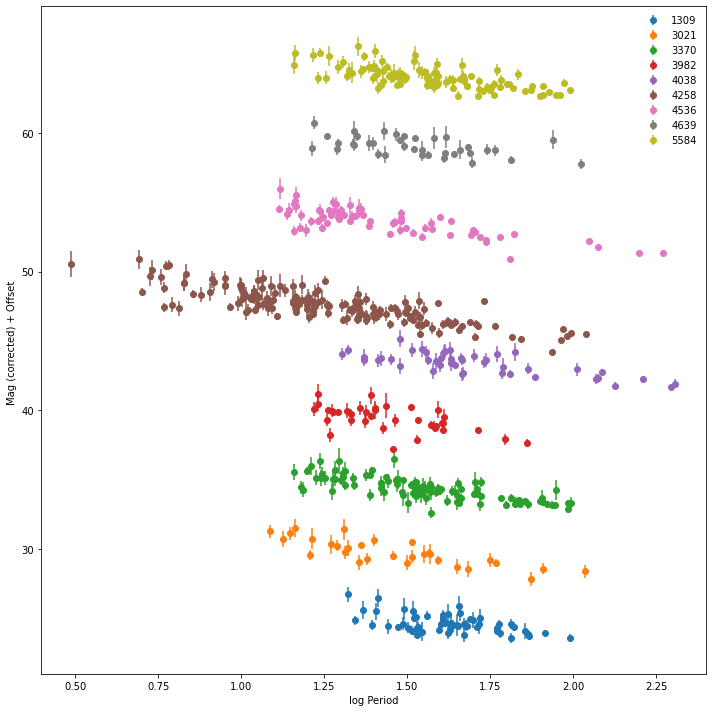

In [2]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


Riess et. al, Equation 1:
\begin{equation}
m^{\text{model}}_{W, i, j} = \left(\mu_{0, i} - \mu_{0, 4258}\right) + zp_{W, 4258} + b_W \log P_{i,j} + Z_W \Delta \log[\text{O/H}]_{i,j}
\end{equation}

The indices $i, j$ represent host galaxy $i$ and Cepheid in that host $j$. $m_W$ is the Wesenheit reddening-free mean magnitude, $\log [\text{O/H}]$ is the metallicity (more specifically, metallicity $- 12$), $\mu_0$ is the reddening-free distance, $b_W$ and $Z_W$ are nuisance parameters, $P$ is the Cepheid period, $\mu_{0, 4258}$ is the reddening-free distance to NGC 4258, and $zp_{4258}$ is the intercept of the $P-L$ relationship fit to NGC 4258 Cepheids.

Ignoring metallicity (e.g. setting $Z_W = 0$),
\begin{equation}
m^{\text{model}}_{W, i, j} = \left(\mu_{0, i} - \mu_{0, 4258}\right) + zp_{W, 4258} + b_W \log P_{i,j}
\end{equation}

$zp_{W, 4258}$ is found by fitting a $P-L$ relationship to all of the NGC 4258 Cepheids. $\mu_{0, 4258}$ is an independent measurement of distance modulus. Riess et al. 2011 obtain it through Herrnstein et al. 1999 water maser measurements. The measured distance in the latter paper is $7.2\pm 0.3$ Mpc. In Humphreys et al. 2013, the distance is found to be $7.60 \pm 0.17 \pm 0.15$ Mpc using an updated model. For distance measured in parsecs, the distance modulus
\begin{equation}
\mu = 5 \log_{10}\left(d\right) - 5
\end{equation}
so $d_{4258} = 7.6$ Mpc corresponds to $\mu_{0, 4258} = 29.4041$

For $i = 4258$, 
\begin{equation}
m^{\text{model}}_{W, 4258, j} = zp_{W, 4258} + b_W \log P_{4258,j}
\end{equation}
so we can get a good prior on $zp_{W, 4258}$ by finding some credible intercepts to the fits of the NGC 4258 Cepheid $P-L$ relationship. Inspecting the NGC 4258 Cepheids,

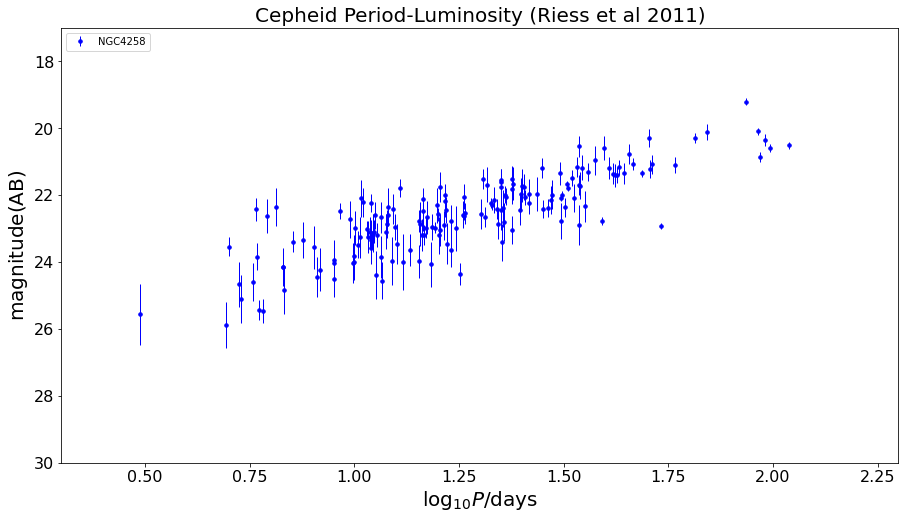

In [3]:
ceph.select('4258')
ceph.plot(4258)
ceph.add_legend()

There aren't any clearly strong outliers, so we can proceed to fitting with a standard Gaussian likelihood. I add in quadrature to the magnitude uncertainty an intrinsic scatter $\sigma_{\text{int}} = 0.08$ mag, which I will justify later on.

In [4]:
# This code is adapted from the HW01 solutions
from scipy import optimize
# define a straight line
def line(a, b, x):
    return a*x + b
# this calculates the z-scaled residual 
def zres(a, b, x, y, dy=1.):
    z = (y - line(a, b, x))/dy
    return z
# Define a standard squared-loss function
def squared_loss(a, b, x, y, dy=1.):
    z = zres(a, b, x, y, dy)
    return np.sum(z**2.)/2. 
slope_range = np.arange(-5, -1, 0.01)
intercept_range = np.arange(25, 28, 0.01)
def eval_loss_func(x, y, dy, a_range, b_range, loss_func):
    loss = np.ones((len(a_range), len(b_range)) )* np.nan
    for i, a in enumerate(a_range):
        for j, b in enumerate(b_range):
            loss[i][j] = loss_func(a, b, x, y, dy)
    imin = loss.argmin()
    i_a, i_b =np.unravel_index(imin, loss.shape)
    a_best_fit = a_range[i_a]
    b_best_fit = b_range[i_b]
    return a_best_fit, b_best_fit, loss, i_a, i_b
slope_fit, intercept_fit, loss_ssr, i_a_ssr, i_b_ssr = eval_loss_func(ceph.logP, 
                                                          ceph.mobs, 
                                                          np.sqrt(ceph.sigma**2 + 0.08**2), 
                                                          slope_range, 
                                                          intercept_range, 
                                                          squared_loss)

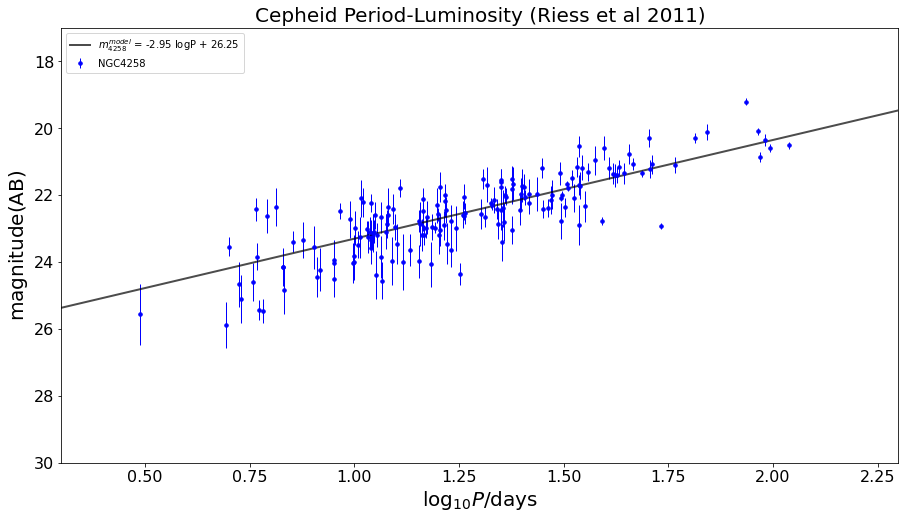

In [5]:
ceph.plot(4258)
ceph.overlay_straight_line_with(a=slope_fit, b=intercept_fit,
                               label=r'$m^{model}_{4258}$'+r' = {:.2f} logP + {:.2f}'.format(slope_fit,
                                                                                            intercept_fit))
ceph.add_legend()

From the intercept of this fit, we define $zp_{W, 4258} = 26.25$

Now we have our model with quantities explicity evaluated for NGC 4258:

\begin{equation}
m^{\text{model}}_{W, i, j} = \left(\mu_{0, i} - 29.4041\right) + 26.25 + b_W \log P_{i,j}
\end{equation}

The Gaussian likelihood (or log likelihood for simplicity) of the Wesenheit reddening-free mean magnitude for the given model  is 
\begin{equation}
\ln L = \text{Constant} - \sum_{i=1}^{N_{\text{hosts}}}\sum_{j=1}^{N_{\text{Cepheids in host i}}} \frac{\left(m_{W, i, j}^{\text{observed}} - m_{W, i, j}^{\text{model}}\right)^2}{2\sigma^2}
\end{equation}

Considering Gaussian magnitude errors, zero period errors, and intrinsic Gaussian dispersion from the $P-L$ relation $\sigma_{\text{int}}$, the total uncertainty $\sigma$ is derived by summing in quadrature, 
\begin{equation}
\sigma^2 = \sigma_{\text{mag}}^2 + \sigma_{\text{int}}^2
\end{equation}
$\sigma_{mag}$ is given in the "merr" column of R11ceph.dat (called via ``` Cepheids('R11ceph.dat').data[:,3] ``` or ```ceph.sigma```).

Riess et. al 2016 (https://arxiv.org/abs/1604.01424) attribute the intrinsic dispersion to the "nonzero temperature width of the Cepheid instability strip." Calibrated against Milky Way Cepheids, they cite $\sigma_{\text{int}} = 0.08$ mag when measuring using the same formulation of Wesenheit index as in the 2011 paper. I use the same 0.08 mag intrinsic dispersion. Besides the fact that there is physical motivation for this intrinsic dispersion, it is good practice to add extra noise to these measurements because the uncertainties are quite small relative to the scatter of the data from the $P-L$ line for each host, indicating that the magnitude uncertainties are not characterizing the full uncertainty in the data.

\begin{equation}
\ln L = \text{Constant} - \sum_{i=1}^{N_{\text{hosts}}}\sum_{j=1}^{N_{\text{Cepheids in host i}}} \frac{\left(m_{W, i, j}^{\text{observed}} - m_{W, i, j}^{\text{model}}\right)^2}{2\left(\sigma^2_{\text{mag},i,j} + \sigma^2_{\text{int}}\right)}
\end{equation}

Writing out the full likelihood, and setting the constant to 0 for simplicity,

\begin{equation}
\ln L = -\sum_{i=1}^{N_{\text{hosts}}}\sum_{j=1}^{N_{\text{Cepheids in host i}}} \frac{ \left(m_{W, i, j}^{\text{observed}} - \left(\mu_{0, i} - \mu_{0, 4258}\right) - zp_{W, 4258} - b_W \log P_{i,j}\right)^2    }{2\left(\sigma_{\text{mag}, i, j}^2 + \sigma_{\text{int}}^2\right)}
\end{equation}

\begin{equation}
\ln L = -\sum_{i=1}^{N_{\text{hosts}}}\sum_{j=1}^{N_{\text{Cepheids in host i}}} \frac{ \left(m_{W, i, j}^{\text{observed}} - \left(\mu_{0, i} - 29.4041\right) - 26.25 - b_W \log P_{i,j}\right)^2    }{2\left(\sigma_{\text{mag}, i, j}^2 + 0.0064 \text{ mag}^2\right)}
\end{equation}

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

The parameter $b_W$ is the slope of the period-magnitude relationship for Cepheids. We know that longer period Cepheids are intrinsically more luminous, and since magnitude and luminousity are inversely related, we can start by constraining $b_W$ to at least be negative. In HW01, problem 2, I used the Huber loss function and ```scipy.optimize.fmin``` to find the slopes of the log period (log days)-Wesenheit index (I - 1.55(V-I), observed with OGLE-III) relationship for LMC and SMC Cepheids to be $\in$ [-3.318, -3.444, -3.473, -3.631], for fundamental and first mode oscillators. In the present data set, period is still measured in days, and the Wesenheit magnitude is calculated using $m_W = \text{F160W} - 0.41(\text{V-I})$ (observed with Hubble WFC3). Even though they are measured using different instruments and different filters, they both correct for reddening effects in the same way. Therefore I motivate the prior on $b_W$ from the LMC and SMC Cepheid $P-L$ relationships. The mean and variance in the slopes listed above is $(\mu, \sigma^2) \sim (-3.4665, 0.0124)$. I widen the corresponding standard deviation ($\sigma \sim 0.111$) by a factor of 3 to not bias the prior too much towards Cepheids of only two galaxies. Using cut-offs $6\sigma$ from the mean, I define the prior on $b_W$

\begin{equation}
P\left(b_W\right) = \begin{cases}
N\left(-3.4665, 0.333\right) & \text{ if } -5.4645 < b_W < -1.4685 \\
0 & \text{ otherwise }
\end{cases}
\end{equation}

The distance modulus $\mu$ relates to distance $d$ by
\begin{equation}
\mu = 5 \log_{10}\left(d\right) - 5
\end{equation}

but really the parameter we are interested in is $\left(\mu_{0, i} - \mu_{0, 4258}\right)$, or
\begin{equation}
\left(\mu_{0, i} - \mu_{0, 4258}\right) = 5\log_{10}\left(\frac{d_i}{d_{4258}}\right)
\end{equation}


We will assume that the population of Cepheids in NGC 4258 is similar to the population of Cepheids among all the other galaxies in the sample. Up to a factor of metallicity, this is physically reasonable. If this is the case, then the reason why the population of short-period Cepheids that appear in NGC 4258 that do not appear in the other galaxies ($\log P \in [0.5, 1.2]$) is because they are too faint to be observed given the distances to the sources (and perhaps to a lesser extent, differences in integration time of the instrument towards different sources). The magnitude difference of the faintest Cepheid in the $i$th host and the faintest Cepheid in NGC 4258 is proportional to their flux ratio:

\begin{equation}
m_{i}^{\text{faintest}} - m_{4258}^{\text{faintest}} = -2.5\log_{10}\left(\frac{F_{i}^{\text{faintest}}}{F_{4258}^{\text{faintest}}}\right) \\
= -2.5\log_{10}\left(\frac{L_{i}^{\text{faintest}}}{L_{4258}^{\text{faintest}}}  \left(\frac{d_{4258}^{\text{faintest}}}{d_{i}^{\text{faintest}}}\right)^2 \right) \\
= -2.5\log_{10}\left(\frac{L_{i}^{\text{faintest}}}{L_{4258}^{\text{faintest}}} \right) + 5\log_{10}\left(\frac{d_{i}^{\text{faintest}}}{d_{4258}^{\text{faintest}}} \right)
\end{equation}

Since
\begin{equation}
M - M_{\odot} = -2.5\log_{10}\left(\frac{L}{L_{\odot}}\right) \\
M_{i}^{\text{faintest}} - M_{4258}^{\text{faintest}} = -2.5\log_{10}\left(\frac{L_i^{\text{faintest}}}{L_{4258}^{\text{faintest}}}\right)
\end{equation}


We already have a guess on the slope of the $P-L$ relationship for Cepheids, $b_W^{\text{fit}}$. For absolute magnitudes, the $P-L$ relationship is
\begin{equation}
M = b_W^{\text{fit}}\log_{10} P + b
\end{equation}
but since we are interested in the difference of magnitudes, we do not need to identify the intercepts for either host.

\begin{equation}
b_W^{\text{fit}} \left(\log_{10} P_i^{\text{faintest}} - \log_{10} P_{4258}^{\text{faintest}}\right)= -2.5\log_{10}\left(\frac{L_i^{\text{faintest}}}{L_{4258}^{\text{faintest}}}\right)
\end{equation}

So 
\begin{equation}
 5\log_{10}\left(\frac{d_{i}^{\text{faintest}}}{d_{4258}^{\text{faintest}}} \right) = \mu_i - \mu_{4258} = \\
 m_{i}^{\text{faintest}} - m_{4258}^{\text{faintest}} - b_W^{\text{fit}} \left(\log_{10} P_i^{\text{faintest}} - \log_{10} P_{4258}^{\text{faintest}}\right)
\end{equation}

In [6]:
count = 1
for h in hosts[hosts != '4258']:
    ceph.select(h)
    minP_i = np.min(ceph.logP)
    maxm_i = np.max(ceph.mobs)
    ceph.select(4258)
    minP_4258 = np.min(ceph.logP)
    maxm_4258 = np.max(ceph.mobs)
    print('mu_'+h+' - mu_4258 guess: ',maxm_i - maxm_4258 - slope_fit*(minP_i - minP_4258))
    count += 1

mu_1309 - mu_4258 guess:  3.3165766500887117
mu_3021 - mu_4258 guess:  2.4210674839138537
mu_3370 - mu_4258 guess:  2.5830175754126508
mu_3982 - mu_4258 guess:  2.4355817788216303
mu_4038 - mu_4258 guess:  1.7013730347499751
mu_4536 - mu_4258 guess:  1.9600403157947448
mu_4639 - mu_4258 guess:  2.00558480962868
mu_5584 - mu_4258 guess:  2.344817575412648


It's clear that all the galaxies are further away than the distance to NGC 4258. This is probably trivially obvious under the assumption that the Cepheid populations are similar in each galaxy, since in the first plot in this notebook, NGC 4258 has a much higher magnitude up to which its observed population is magnitude-limited. Further, the range of distance moduli relative to NGC 4258 is appxoimately in [1.5, 3.5]. This range is motivated by our knowledge that these galaxies are selected to have observed Cepheids and SN Ia. SN Ia, as standard candles, don't have a great variance in total energy, they all release $\sim 10^{51}$ ergs, which effectively sets an upper limit to the distance moduli we can expect in this sample. The lower limit is set by small number statistics of the number of galaxies in a decreasing volume of space over which you search for SN Ia and sufficiently bright and numerous Cepheids to perform these methods. Since $\mu$ relates to $d$ logarithmically, we don't want to make our constraints too wide, because this would correspond to distances much further outside the range of reasonable values than we may naively think we are covering. 

I therefore define the following priors:
\begin{equation}
P\left(\mu_{0, i} - \mu_{0, 4258}\right) = \begin{cases}
N(\left(\mu_{i} - \mu_{4258}\right)^{\text{guess}}, 1) & \text{ if } 5.0 > \mu_{0, i} - \mu_{0, 4258} > 0.5 \\
0 & \text{ otherwise}
\end{cases}
\end{equation}
for $i\neq 4258$ and the following guesses:

| $i$      | <div style="width:150px">$\left(\mu_{i} - \mu_{4258}\right)^{\text{guess}}$</div> |
| --- | ---------------- |
| 1309 | 3.317 |
| 3021 | 2.421 |
| 3370 | 2.583 |
| 3982 | 2.436 |
| 4038 | 1.701 |
| 4536 | 1.960 |
| 4639 | 2.006 |
| 5584 | 2.345 |


Riess et al. 2011 give the approximation for $a_v$ in terms of redshift and supernova magnitude
\begin{equation}
a_v \approx \log cz - 0.2 m_v^0
\end{equation}

In Table 3, the parameter given is $m_v^0 + 5a_v$ which can be evaluated as
\begin{equation}
m_v^0 + 5a_v \approx m_v^0 + 5\log cz -  m_v^0 = 5\log cz
\end{equation}

Riess et al. Equation 4 is
\begin{equation}
\log H_0 = \frac{\left(m^0_{v, i} - \mu_{0, i} \right) + 5a_v + 25}{5}
\end{equation}

so 

\begin{equation}
\log H_0 = \frac{ - \mu_{0, i} + 25 + 5\log c z_{i}}{5}
\end{equation}

Rearranging, 
\begin{equation}
\mu_{0, i} =   25 + 5\log c z_i -5\log H_0
\end{equation}

This is contingent upon the value of $H_0$ being chosen appropriately, but previous works have found $H_0$ in a range, which gives some prior knowledge of the range that $\mu_{0, i}$ could be found in. Gravitational waves offer an independent measurement of $H_0$. The LIGo Scientific Collaboration and The Virgo Collaboration et al. 2017 (https://ui.adsabs.harvard.edu/abs/2017Natur.551...85A/abstract) report $H_0 = 70^{+12.0}_{-8.0} \text{km s}^{-1} \text{Mpc}^{-1}$ with 68.3% credible intervals. For consistency, we can check our guesses on $\mu_{0,i} - \mu_{0, 4258}$ with an independent measurement of $H_0$. From Humphreys et al. 2013 maser measurements, $\mu_{0, 4258} \approx 29.4041$.
<!--  Therefore we can use the 68.3% limits, 62 and 82, to determine the range of the prior on $\mu_{0, i} - \mu_{0, 4258}$.-->

In [8]:
redshift_data = np.loadtxt('R11redsh.dat')

In [43]:
for enum_h, h in enumerate(hosts):
    if h != '4258':
        for h0_now in [70]:
            print(str(h)+\
                  ', H0={}, mu_i-mu_4258 = {:.3f}'.format(h0_now,
                  25. + 5.*np.log10(3e5 * redshift_data[enum_h,1]) -5*np.log10(h0_now) - (5.*np.log10(7.6e6)-5)))

1309, H0=70, mu_i-mu_4258 = 3.020
3021, H0=70, mu_i-mu_4258 = 2.311
3370, H0=70, mu_i-mu_4258 = 1.906
3982, H0=70, mu_i-mu_4258 = 1.596
4038, H0=70, mu_i-mu_4258 = 2.449
4536, H0=70, mu_i-mu_4258 = 2.658
4639, H0=70, mu_i-mu_4258 = 1.410
5584, H0=70, mu_i-mu_4258 = 2.444


| $i$      | <div style="width:300px">$\left(\mu_{i} - \mu_{4258}\right)^{\text{guess}} - \left(\mu_{i} - \mu_{4258}\right)^{\text{GW }H_0}$</div> |
| --- | ---------------- |
| 1309 | 0.297 |
| 3021 | 0.110 |
| 3370 | 0.677 |
| 3982 | 0.840 |
| 4038 | -0.748 |
| 4536 | -0.698 |
| 4639 | 0.596 |
| 5584 | -0.099 |

These two guesses on $\mu_{0,i}-\mu_{0,4258}$ are roughly consistent within the constraints I have set on the priors, so I will proceed with the priors based on apparent magnitude and period differences.

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [14]:
def model(params, *args):
    mW, merr, logP = args
    bW, relative_distance_mods = params
    zpW4258 = 26.25
    return relative_distance_mods + zpW4258 + bW*logP

def likelihood(params):

    bW, mu1309, mu3021, mu3370, mu3982, mu4038, mu4536, mu4639, mu5584 = params
    relative_distance_mods = np.array([mu1309, mu3021, mu3370, mu3982, mu4038, mu4536, mu4639, mu5584])
    log_like = 0.
    sigma_intrinsic = 0.03
    for enum_h, h in enumerate(hosts[hosts != '4258']):
        ceph.select(h)
        mW = ceph.mobs
        merr = ceph.sigma
        logP = ceph.logP
        diff = mW - model((bW, relative_distance_mods[enum_h]), *(mW, merr, logP))
        noise = np.sqrt(merr**2 + sigma_intrinsic**2)
        log_like -= np.sum((diff**2)/(2.*noise**2))
    
    ceph.select('4258')
    mW = ceph.mobs
    merr = ceph.sigma
    logP = ceph.logP
    diff = mW - model((bW, 0), *(mW, merr, logP))
    noise = np.sqrt(merr**2 + sigma_intrinsic**2)
    log_like -= np.sum((diff**2)/(2.*noise**2))
    
    return log_like
        

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def prior(params):
    bW, mu1309, mu3021, mu3370, mu3982, mu4038, mu4536, mu4639, mu5584 = params
    relative_distance_mods = np.array([mu1309, mu3021, mu3370, mu3982, mu4038, mu4536, mu4639, mu5584])
    if (-5.4645 < bW) and (bW < -1.4658):
        log_prior_bW = np.log(gaussian(bW, -3.4665, 0.333))
    else:
        return -np.inf
    
    # for now, just to test, give tophat priors, but change them later
    if all(relative_distance_mods > 0.5) and all(relative_distance_mods < 5.):
        p1309 = np.log(gaussian(mu1309, 3.317, 1.0))
        p3021 = np.log(gaussian(mu3021, 2.421, 1.0))
        p3370 = np.log(gaussian(mu3370, 2.583, 1.0))
        p3982 = np.log(gaussian(mu3982, 2.436, 1.0))
        p4038 = np.log(gaussian(mu4038, 1.701, 1.0))
        p4536 = np.log(gaussian(mu4536, 1.960, 1.0))
        p4639 = np.log(gaussian(mu4639, 2.006, 1.0))
        p5584 = np.log(gaussian(mu5584, 2.345, 1.0))
        
        log_prior_relative_distances = np.sum([p1309,
                                                p3021,
                                                p3370,
                                                p3982,
                                                p4038,
                                                p4536,
                                                p4639,
                                                p5584])
    else:
        return -np.inf
    
    return log_prior_bW + log_prior_relative_distances



def posterior(params):
    return likelihood(params) + prior(params)

In [15]:
import emcee

In [16]:
ndims = (len(hosts) - 1) + 1 # number of parameters in the model = 
# the set of mu_0,i, excluding NGC 4258, plus bW
nwalkers = 20 # number of MCMC walkers

nburn = 1000
nsteps = 5000

In [17]:
init_guesses = np.ones(ndims)
init_guesses[0] = -3.5
init_guesses[1:] = np.array([3.317,
                            2.421,
                            2.583,
                            2.436,
                            1.701,
                            1.960,
                            2.006,
                            2.345])

In [18]:
p0 = init_guesses*(1. + 0.1*np.ones(ndims)*np.random.random((nwalkers,ndims)))

In [19]:
sampler = emcee.EnsembleSampler(nwalkers, 
                                ndims, 
                                posterior)
state = sampler.run_mcmc(p0, nburn, progress=True)
sampler.reset()
sampler.run_mcmc(state, nsteps, progress=True)

100%|██████████| 5000/5000 [01:05<00:00, 76.59it/s]


State([[-2.91113789  3.09033762  2.8747314   2.67931303  2.19876686  2.10111618
   1.45189931  2.35140988  2.19668054]
 [-2.93531393  3.09162817  2.86555054  2.69564028  2.30914458  2.04842294
   1.47906402  2.2529808   2.23300106]
 [-2.94514761  3.09014087  2.86661328  2.69935082  2.30975884  2.01418352
   1.47329097  2.29055412  2.30998342]
 [-2.94976059  3.17129802  2.89015989  2.66757596  2.19209893  2.10643993
   1.52822285  2.35353596  2.29258066]
 [-2.94146349  3.14374103  2.83163599  2.74167046  2.22599322  2.11833833
   1.47382522  2.28129731  2.28015865]
 [-2.94410036  3.21178169  3.0193468   2.69404445  2.17402207  2.03019441
   1.49708649  2.30696246  2.31335941]
 [-2.92986277  3.07243775  2.80415054  2.69397171  2.22472506  2.20106634
   1.52726745  2.30443334  2.27249463]
 [-2.93511836  3.16261158  2.88125988  2.71069116  2.23236526  2.14029414
   1.48332759  2.16431936  2.28473683]
 [-2.95592016  3.16015395  2.91341154  2.74377802  2.19600812  2.18703252
   1.50535481  2

In [20]:
samples = sampler.get_chain(flat=True)

In [21]:
labels = [r'$b_W$']
for h in hosts[hosts != '4258']:
    labels += [r'$\mu_{'+str(h)+'} - \mu_{4258}$']

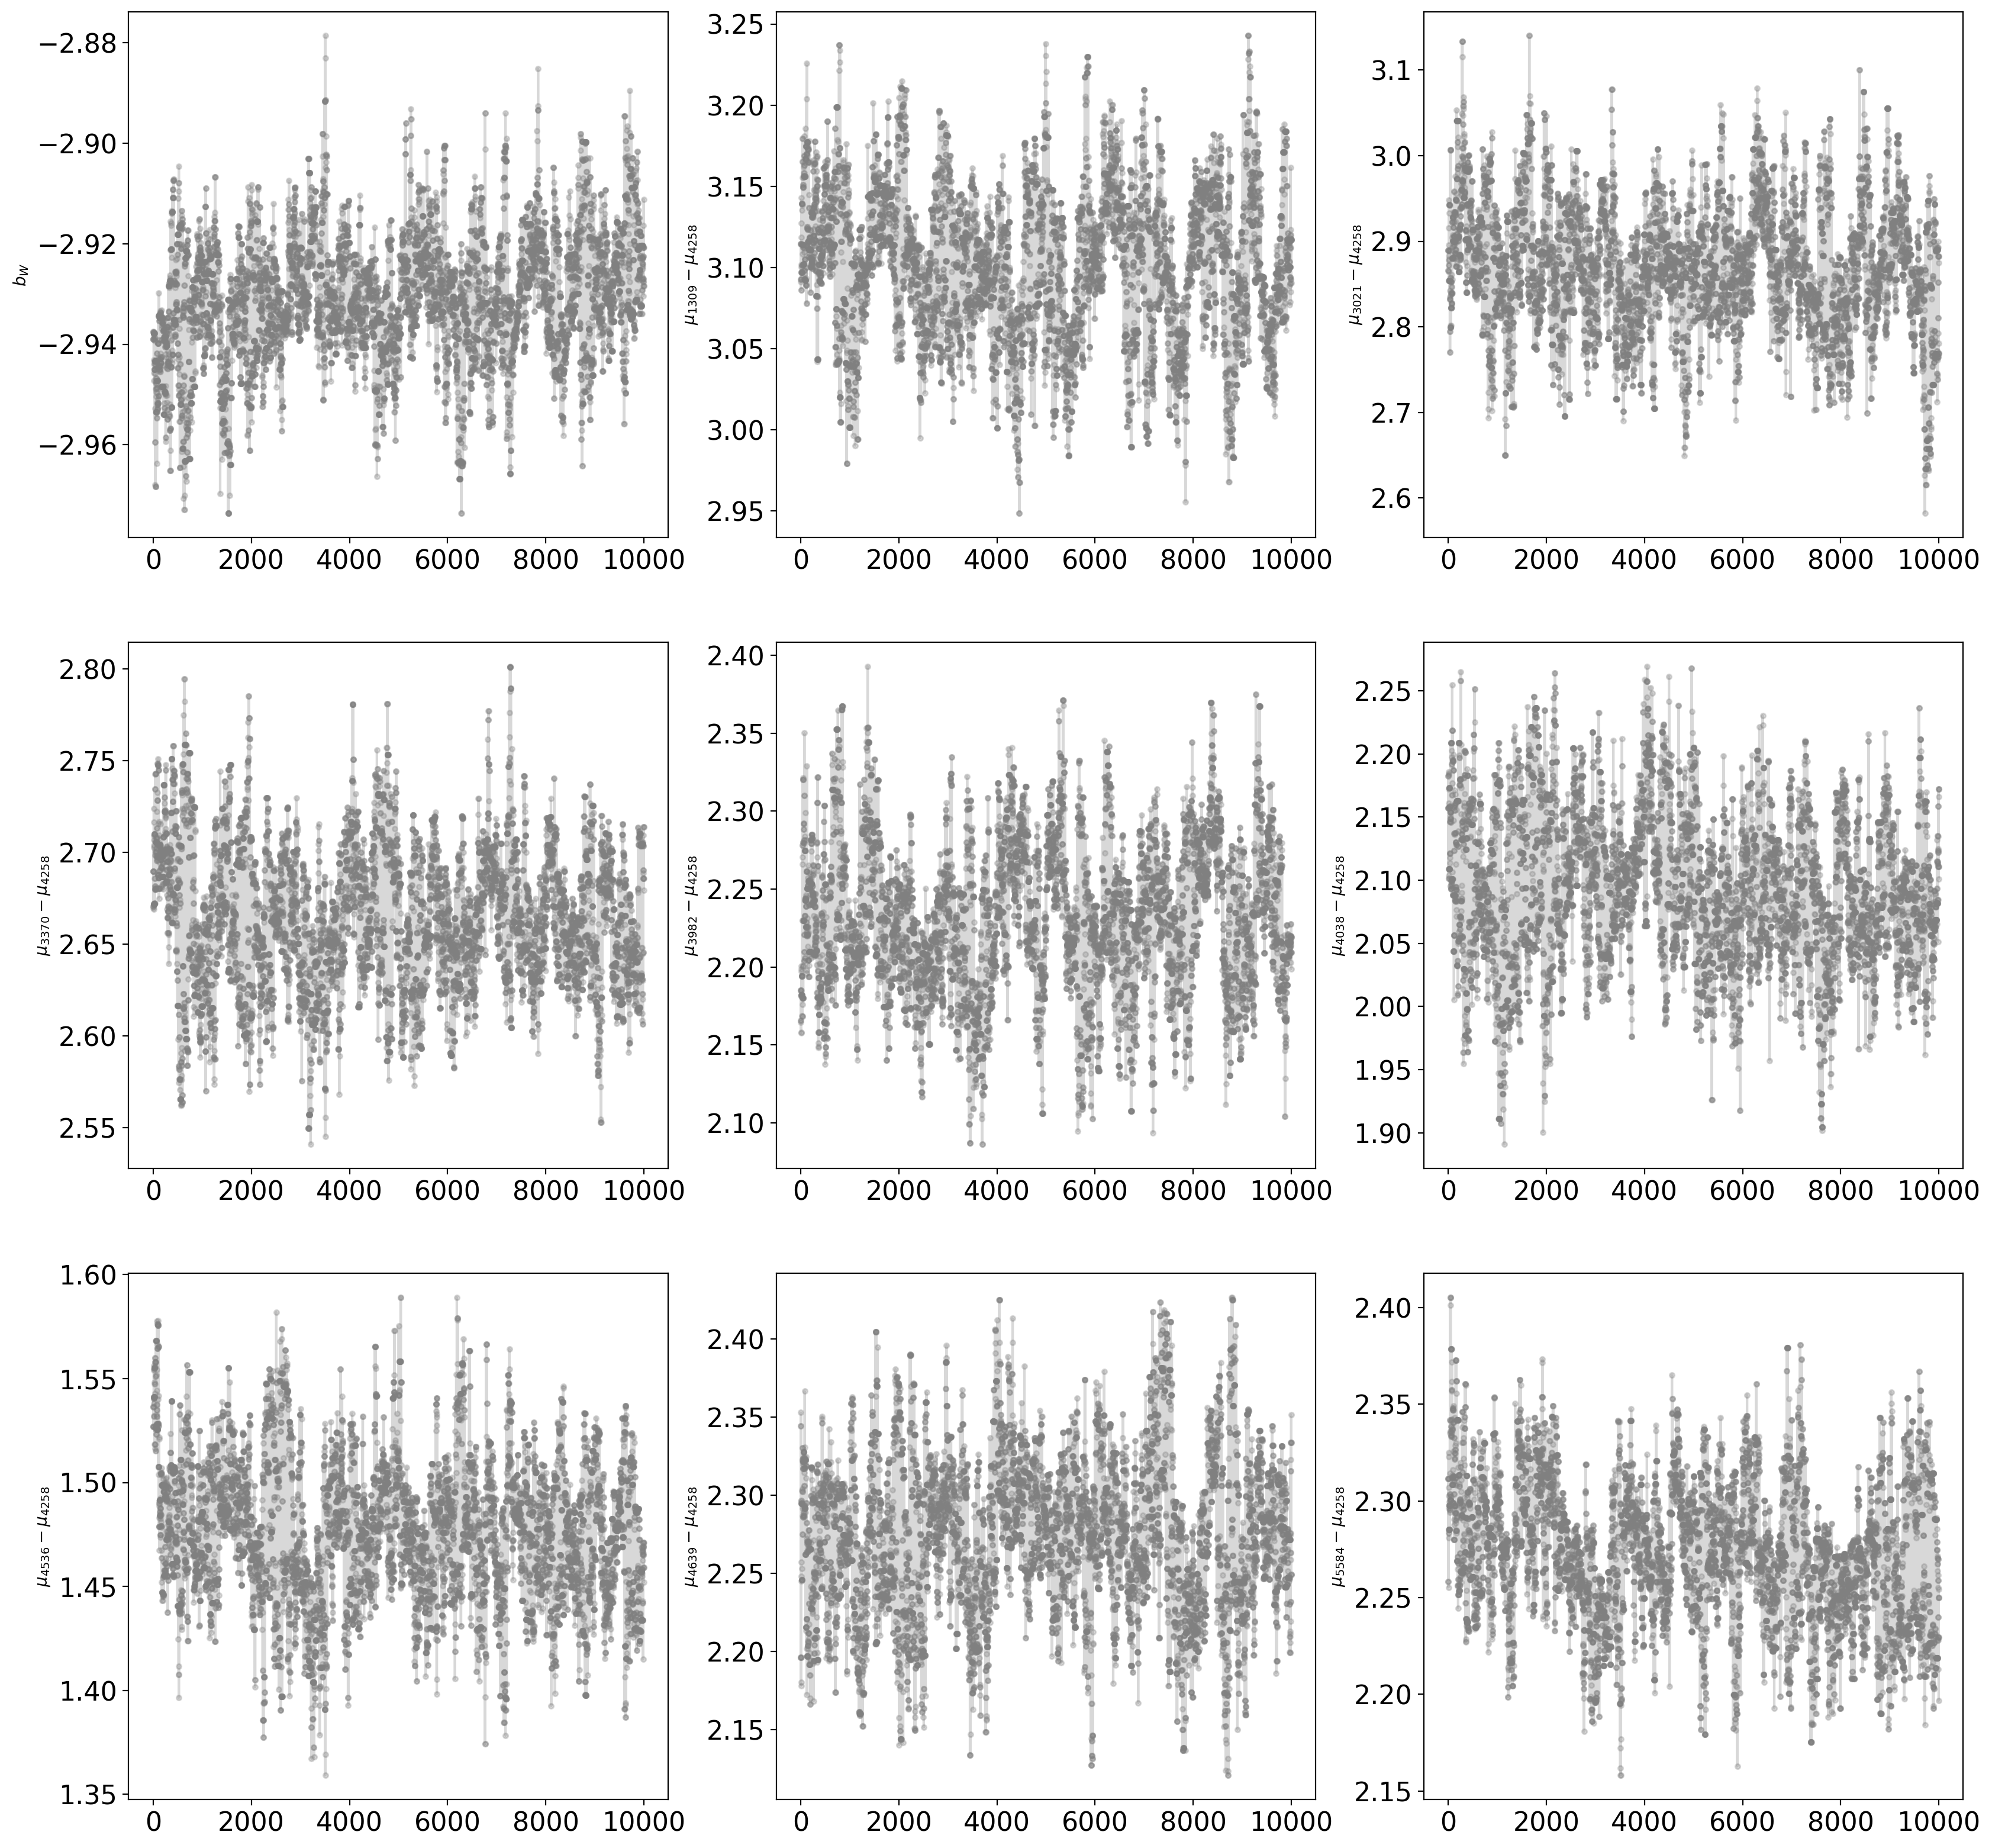

In [22]:
plt.figure(figsize=(20,20),dpi=200)
for num in range(9):
    plt.subplot(3,3,num+1)
    plt.plot(samples[::10,num],marker='.',alpha=0.3,c='grey')
    plt.ylabel(labels[num])

I performed 1000 burn-in steps, followed by 5000 steps with 20 walkers. After the initial burn-in, there does not appear to be significant burn-in in the flattened chains. I thin the chain by a factor of 10 to reduce autocorrelation.

In [23]:
from corner import corner

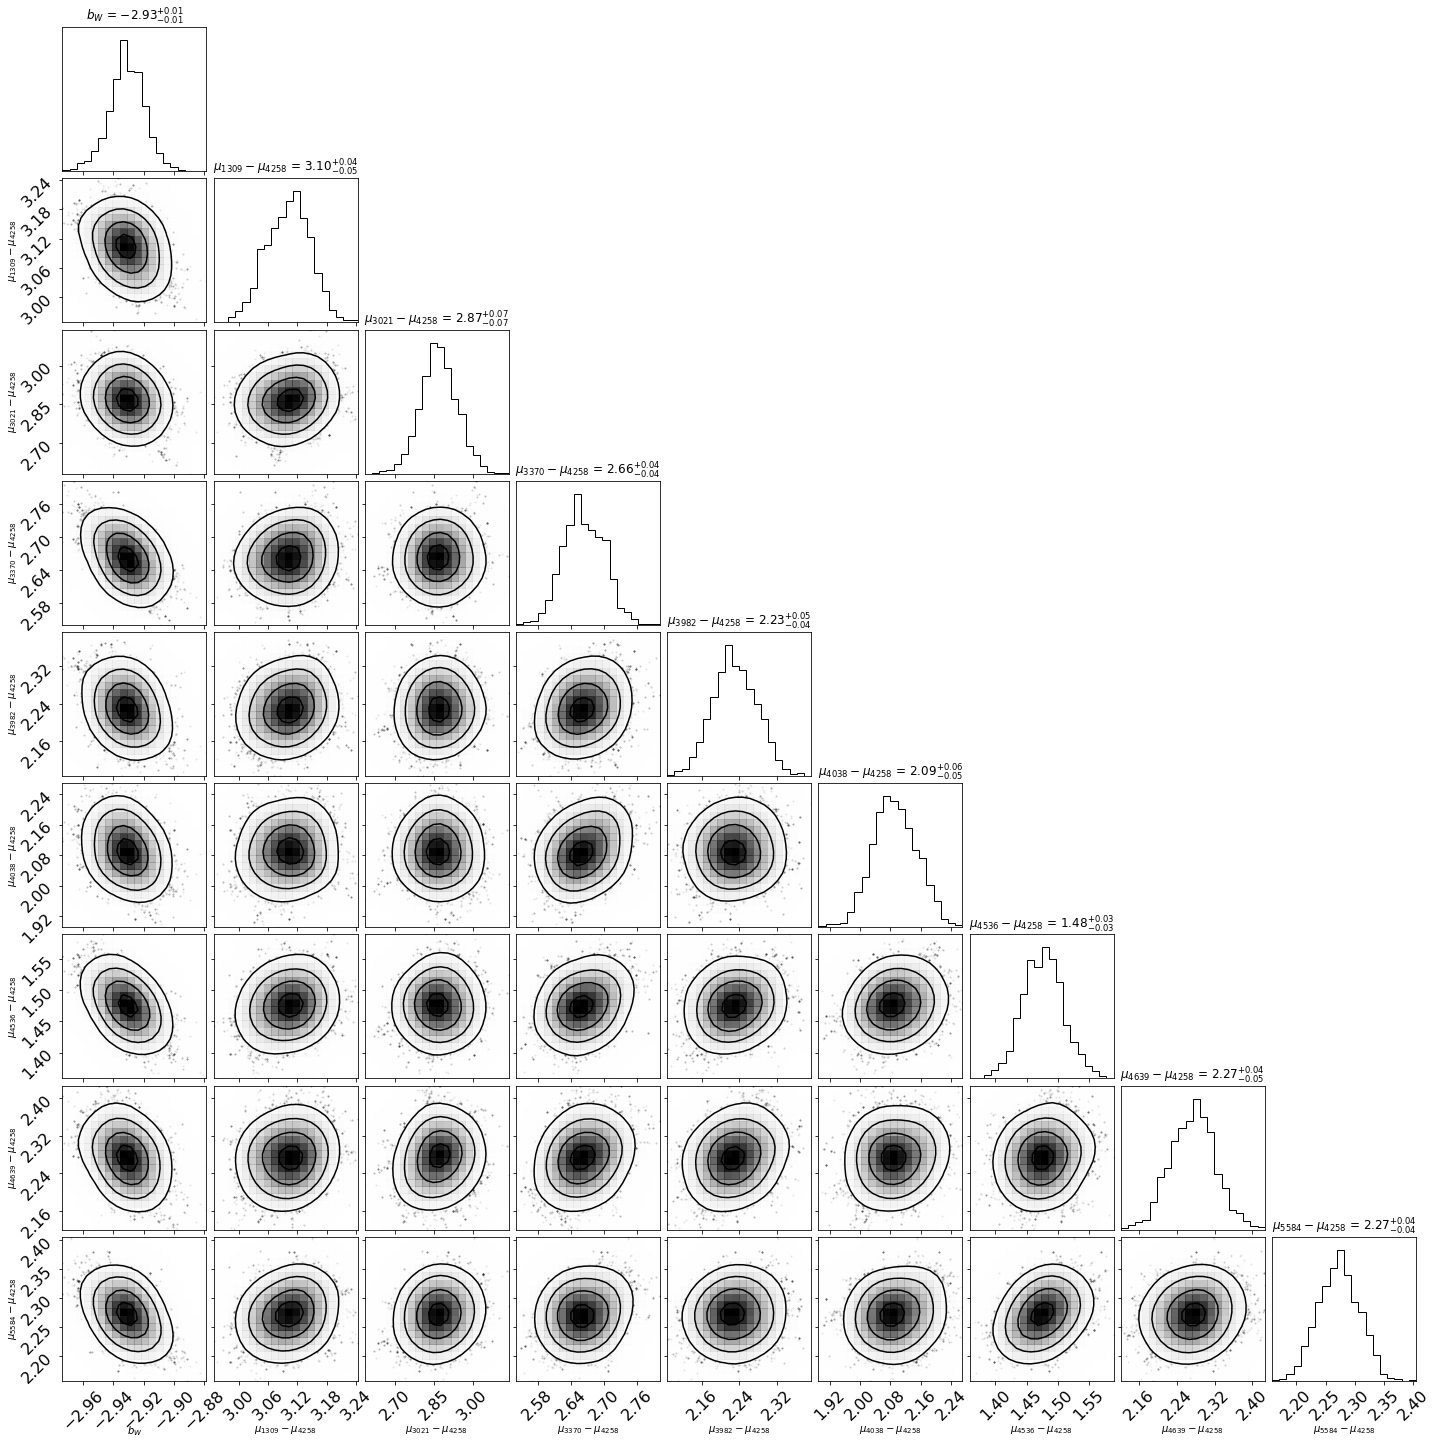

In [24]:
fig = corner(samples[::10,:], plot_contours=True, show_titles=True, smooth=2, labels=labels)

The corner plots show slight correlation between some of the parameters, especially the $\mu_{i}-\mu_{4258}$ with $b_W$. The parameters all show unimodal, nearly gaussian distributions. There is no degeneracy in the parameters. 

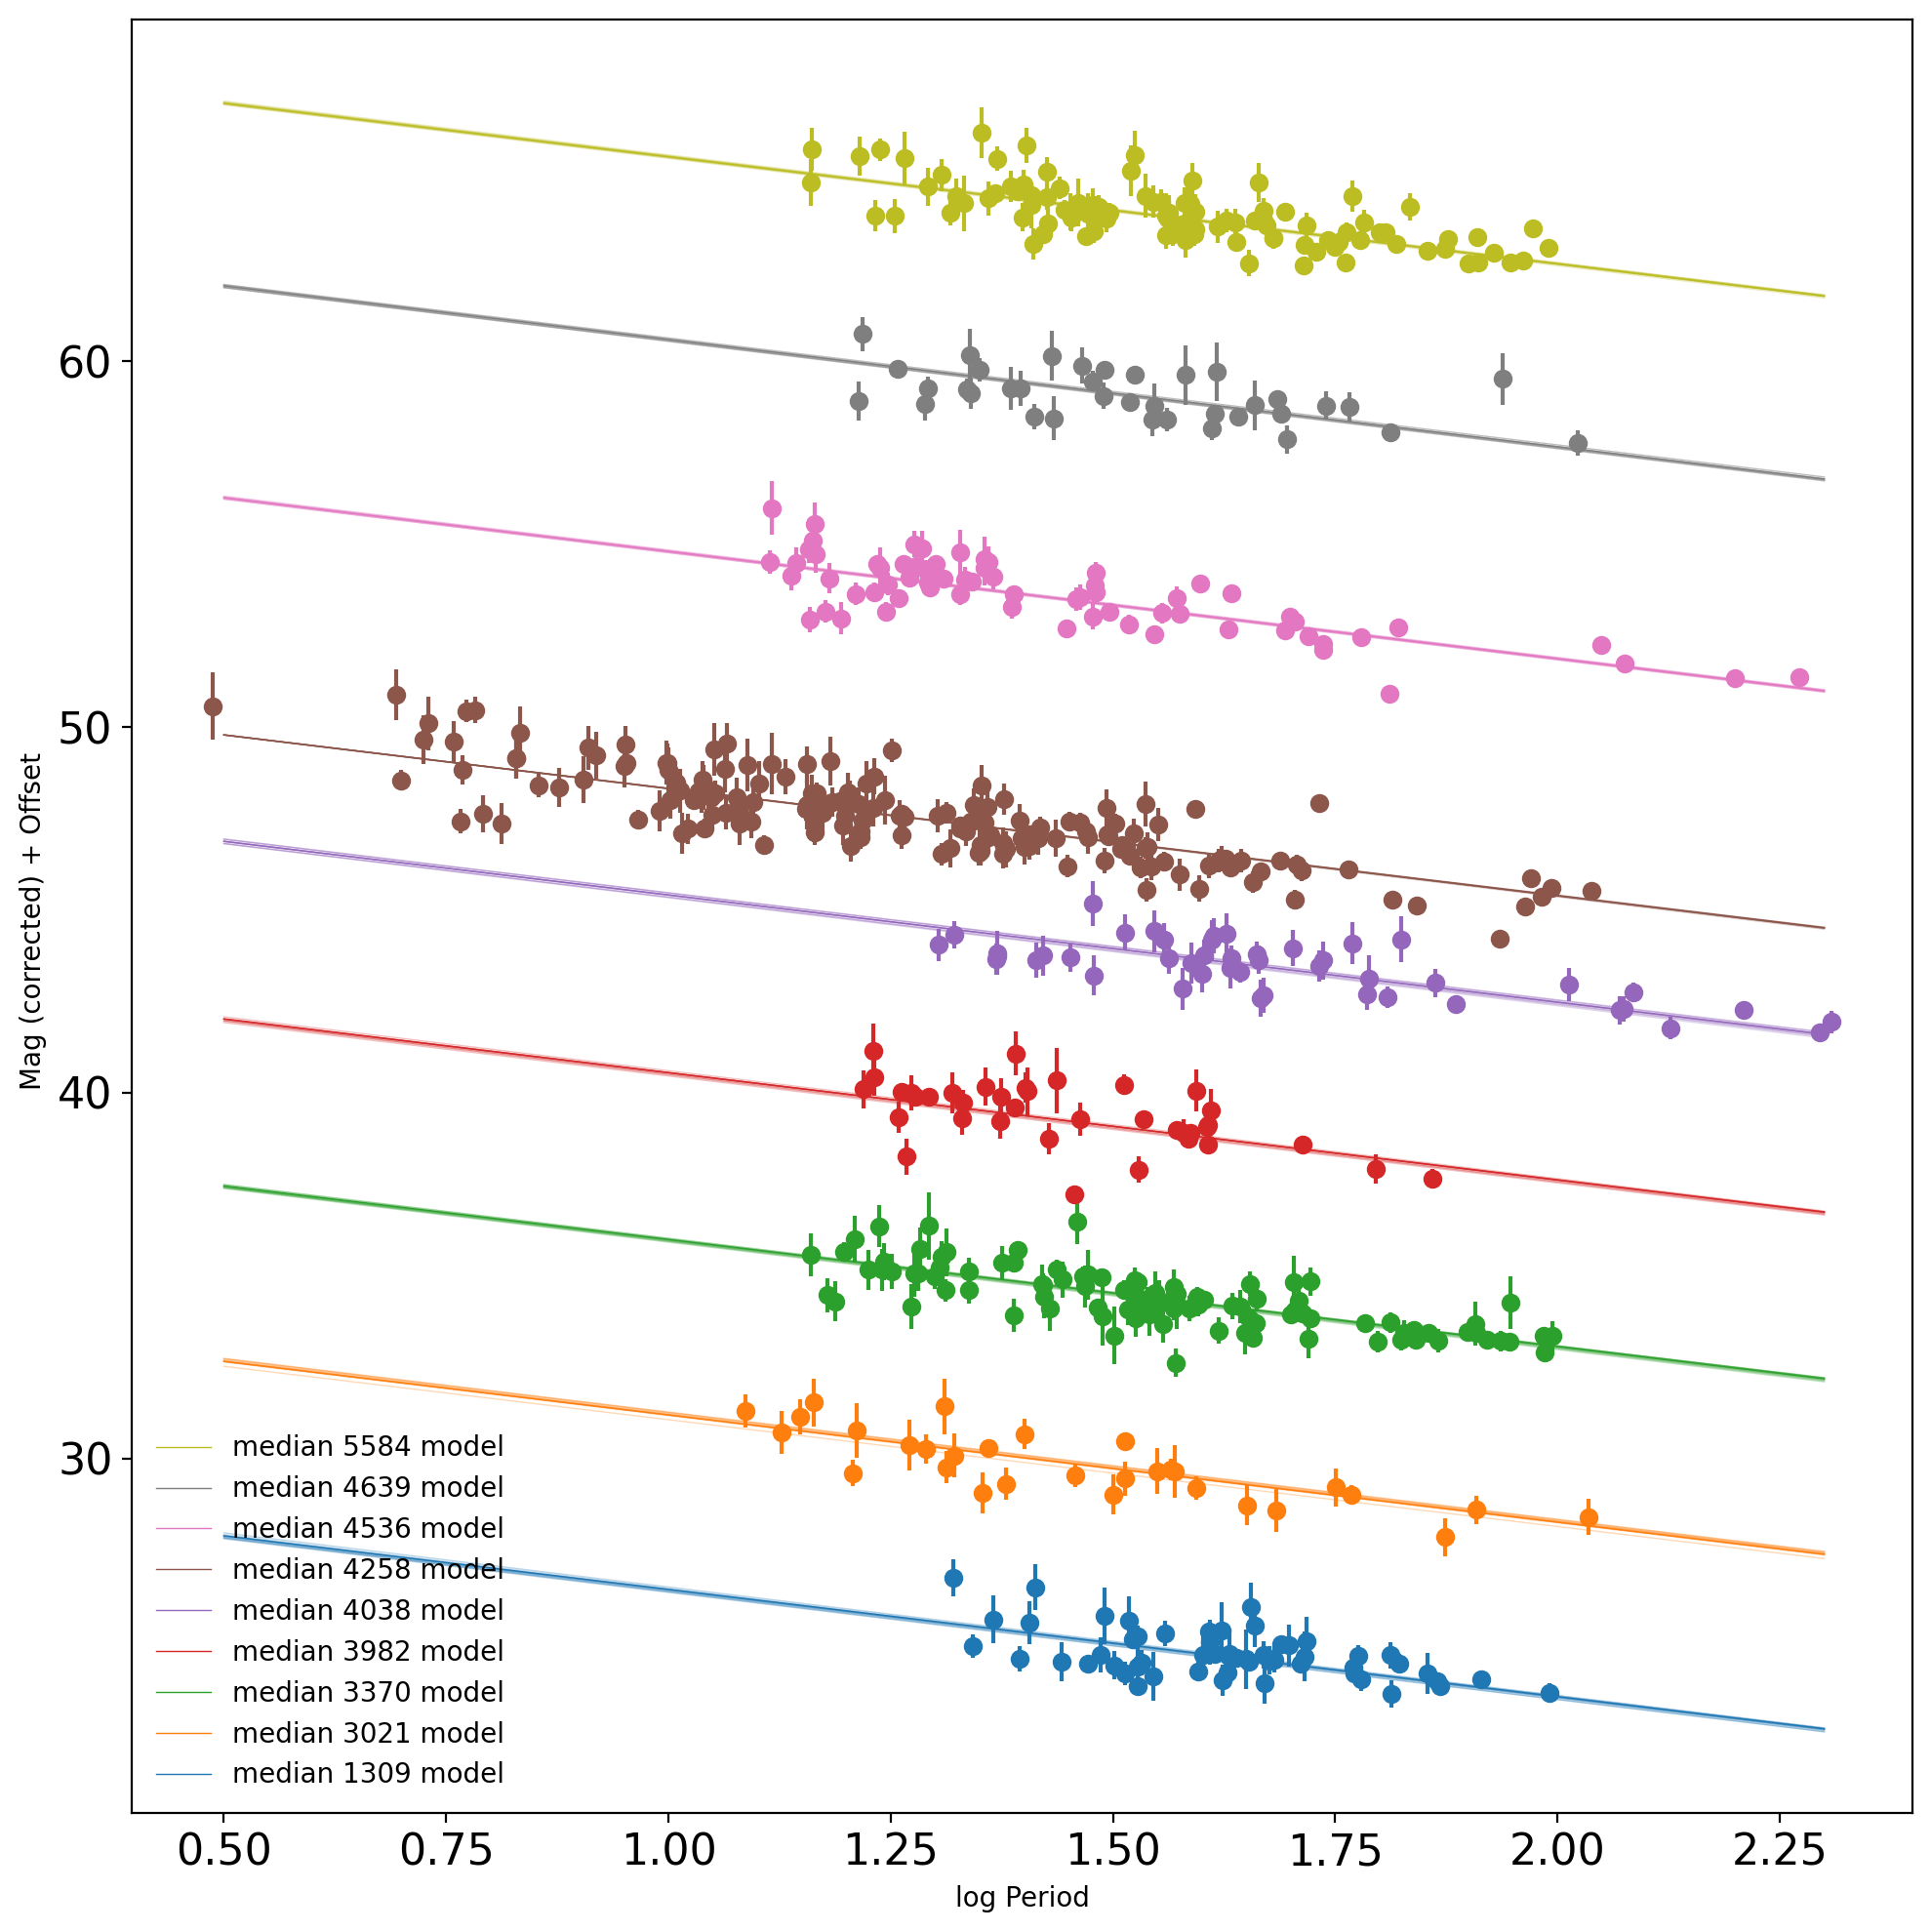

In [25]:
fig = plt.figure(figsize=(10, 10),dpi=200)
ax = fig.add_subplot(111)
thinned_chain = samples[::10,:]
count = 1
for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', #label=ID,
               c = 'C'+str(i))
    
    if ID != '4258':
        mu_reduced = np.median(samples, axis=0)[count]
        mock_periods = np.linspace(0.5, 2.3, 10)
        ax.plot(mock_periods, (5*i)+model((np.median(thinned_chain, axis=0)[0], np.median(samples, axis=0)[count]),
                                   *(mobs, sigma_obs, np.linspace(0.5, 2.3, 10))), c = 'C'+str(i),
               label='median '+ID+' model',linewidth=0.5)
        for test in np.random.randint(0, len(thinned_chain), size=10):
            ax.plot(mock_periods, (5*i)+model((thinned_chain[test,0], thinned_chain[test,count]),
                                   *(mobs, sigma_obs, np.linspace(0.5, 2.3, 10))), c = 'C'+str(i),
               alpha=0.3,linewidth=0.5)
        count += 1
    else:
        mock_periods = np.linspace(0.5, 2.3, 10)
        ax.plot(mock_periods, (5*i)+model((np.median(thinned_chain, axis=0)[0], 0),
                                   *(mobs, sigma_obs, np.linspace(0.5, 2.3, 10))), c = 'C'+str(i),
               label='median '+ID+' model',linewidth=0.5)
        for test in np.random.randint(0, len(thinned_chain), size=10):
            ax.plot(mock_periods, (5*i)+model((thinned_chain[test,0], 0),
                                   *(mobs, sigma_obs, np.linspace(0.5, 2.3, 10))), c = 'C'+str(i),
               alpha=0.3,linewidth=0.5)
        
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

### If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

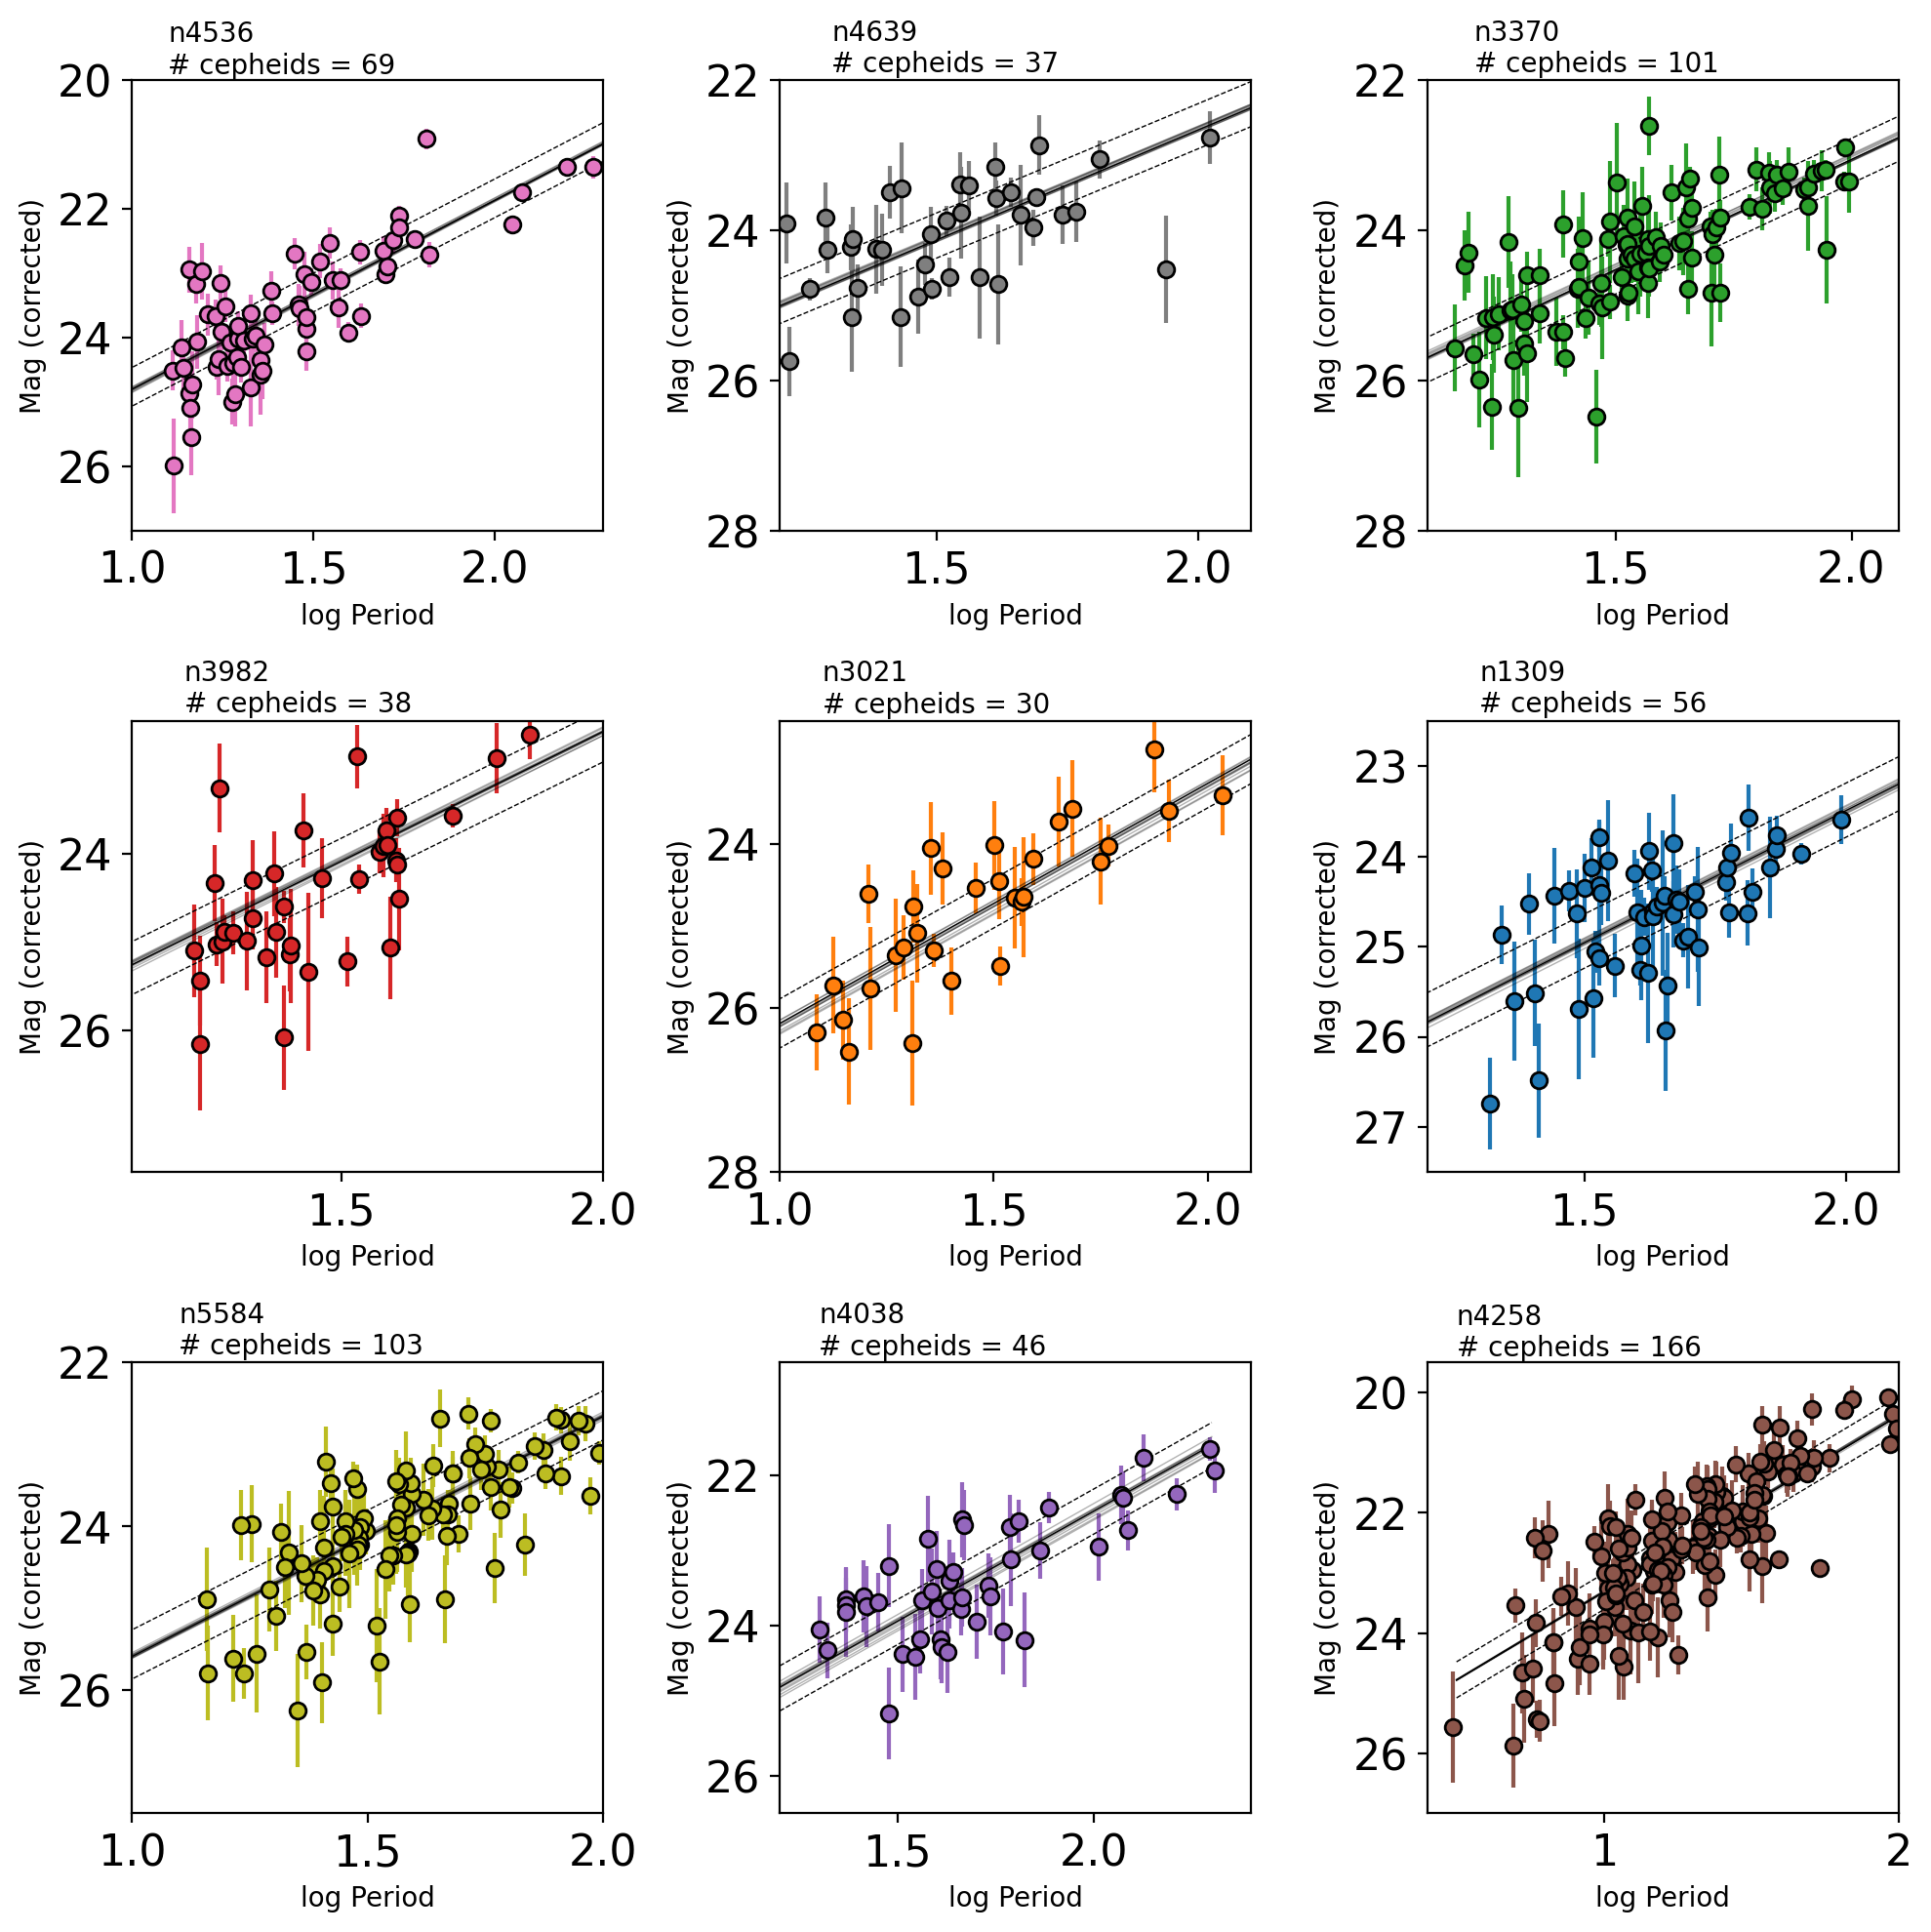

In [40]:
fig = plt.figure(figsize=(10, 10),dpi=200)

count = 1
ylim_dict = {}
ylim_dict['4536'] = (27, 20)
ylim_dict['4639'] = (28, 22)
ylim_dict['3370'] = (28, 22)
ylim_dict['3982'] = (27.6, 22.5)
ylim_dict['3021'] = (28, 22.5)
ylim_dict['1309'] = (27.5, 22.5)
ylim_dict['5584'] = (27.5, 22)
ylim_dict['4038'] = (26.5, 20.5)
ylim_dict['4258'] = (27, 19.5)

xlim_dict = {}
xlim_dict['4536'] = (1.0, 2.3)
xlim_dict['4639'] = (1.2, 2.1)
xlim_dict['3370'] = (1.1, 2.1)
xlim_dict['3982'] = (1.1, 2.0)
xlim_dict['3021'] = (1.0, 2.1)
xlim_dict['1309'] = (1.2, 2.1)
xlim_dict['5584'] = (1.0, 2.0)
xlim_dict['4038'] = (1.2, 2.4)
xlim_dict['4258'] = (0.4, 2.0)

position_dict = {}
position_dict['4536'] = 1
position_dict['4639'] = 2
position_dict['3370'] = 3
position_dict['3982'] = 4
position_dict['3021'] = 5
position_dict['1309'] = 6
position_dict['5584'] = 7
position_dict['4038'] = 8
position_dict['4258'] = 9


for i, ID in enumerate(hosts):
    ax = fig.add_subplot(3, 3, position_dict[ID])
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', marker='o', #label=ID,
               c = 'C'+str(i), mec='k')
    
    if ID != '4258':
        mu_reduced = np.median(samples, axis=0)[count]
        mock_periods = np.linspace(0.5, 2.3, 10)
        ax.plot(mock_periods, model((np.median(thinned_chain, axis=0)[0], np.median(samples, axis=0)[count]),
                                   *(mobs, sigma_obs, np.linspace(0.5, 2.3, 10))), c = 'k',
               linewidth=0.5)
        for test in np.random.randint(0, len(thinned_chain), size=10):
            ax.plot(mock_periods, model((thinned_chain[test,0], thinned_chain[test,count]),
                                   *(mobs, sigma_obs, np.linspace(0.5, 2.3, 10))), c = 'k',
               alpha=0.3,linewidth=0.5)
        ax.plot(mock_periods, 0.3 + model((thinned_chain[test,0], thinned_chain[test,count]),
                                   *(mobs, sigma_obs, np.linspace(0.5, 2.3, 10))), c = 'k',
               alpha=1,linewidth=0.5, linestyle = '--')
        ax.plot(mock_periods, -0.3 + model((thinned_chain[test,0], thinned_chain[test,count]),
                                   *(mobs, sigma_obs, np.linspace(0.5, 2.3, 10))), c = 'k',
               alpha=1,linewidth=0.5, linestyle = '--')
        count += 1
    else:
        mock_periods = np.linspace(0.5, 2.3, 10)
        ax.plot(mock_periods, model((np.median(thinned_chain, axis=0)[0], 0),
                                   *(mobs, sigma_obs, np.linspace(0.5, 2.3, 10))), c = 'k',
               linewidth=0.5)
        for test in np.random.randint(0, len(thinned_chain), size=10):
            ax.plot(mock_periods, model((thinned_chain[test,0], 0),
                                   *(mobs, sigma_obs, np.linspace(0.5, 2.3, 10))), c = 'k',
               alpha=0.3,linewidth=0.5)
        ax.plot(mock_periods, 0.3 + model((thinned_chain[test,0], 0),
                                   *(mobs, sigma_obs, np.linspace(0.5, 2.3, 10))), c = 'k',
               alpha=1,linewidth=0.5, linestyle='--')
        ax.plot(mock_periods, -0.3 + model((thinned_chain[test,0], 0),
                                   *(mobs, sigma_obs, np.linspace(0.5, 2.3, 10))), c = 'k',
               alpha=1,linewidth=0.5, linestyle='--')
    ax.set_ylim(ylim_dict[ID])
    ax.set_xlim(xlim_dict[ID])
    ax.text(xlim_dict[ID][0] + 0.1, ylim_dict[ID][1] - 0.1, 'n'+ID+'\n'+'# cepheids = {}'.format(len(mobs)))
    
        
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], frameon=False)
    ax.set_xlabel('log Period')
    ax.set_ylabel('Mag (corrected)')
fig.tight_layout()

Immediately obvious from comparing this figure to Riess et al. 2011 Figure 7 is that the number of Cepheids in each host is different. This is because they perform outlier rejection, which I do not. My # cepheids is greater than theirs for each host. Otherwise, these figures are quite similar. I express uncertainty in the model parameters by plotting 10 random draws from the chain in lower opacity, while the median parameters from the chain after removing 1000 steps of burn-in are drawn with no transparency. Like Riess et al. Figure 7, I mark 0.3 mag dispersion with the black dashed lines.

### Compare the intercept you find for the intercepts $\mu_{0, i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [28]:
from astropy.table import Table

In [29]:
table3 = Table.read('Riess_table3.dat',format='ascii.csv',
                    names=['Host', 'SN_Ia', 'Filters', 'm0vi+5av', 'sigma', 'mu0i-mu04258', 'mu0Best'],
                   delimiter=' ',comment='#',data_start=0)
table3_mu_minus_mu = [float(f.split('(')[0]) for f in table3['mu0i-mu04258']]
table3_mu_minus_mu_sigma = [float(f.split('(')[1][:-1]) for f in table3['mu0i-mu04258']]

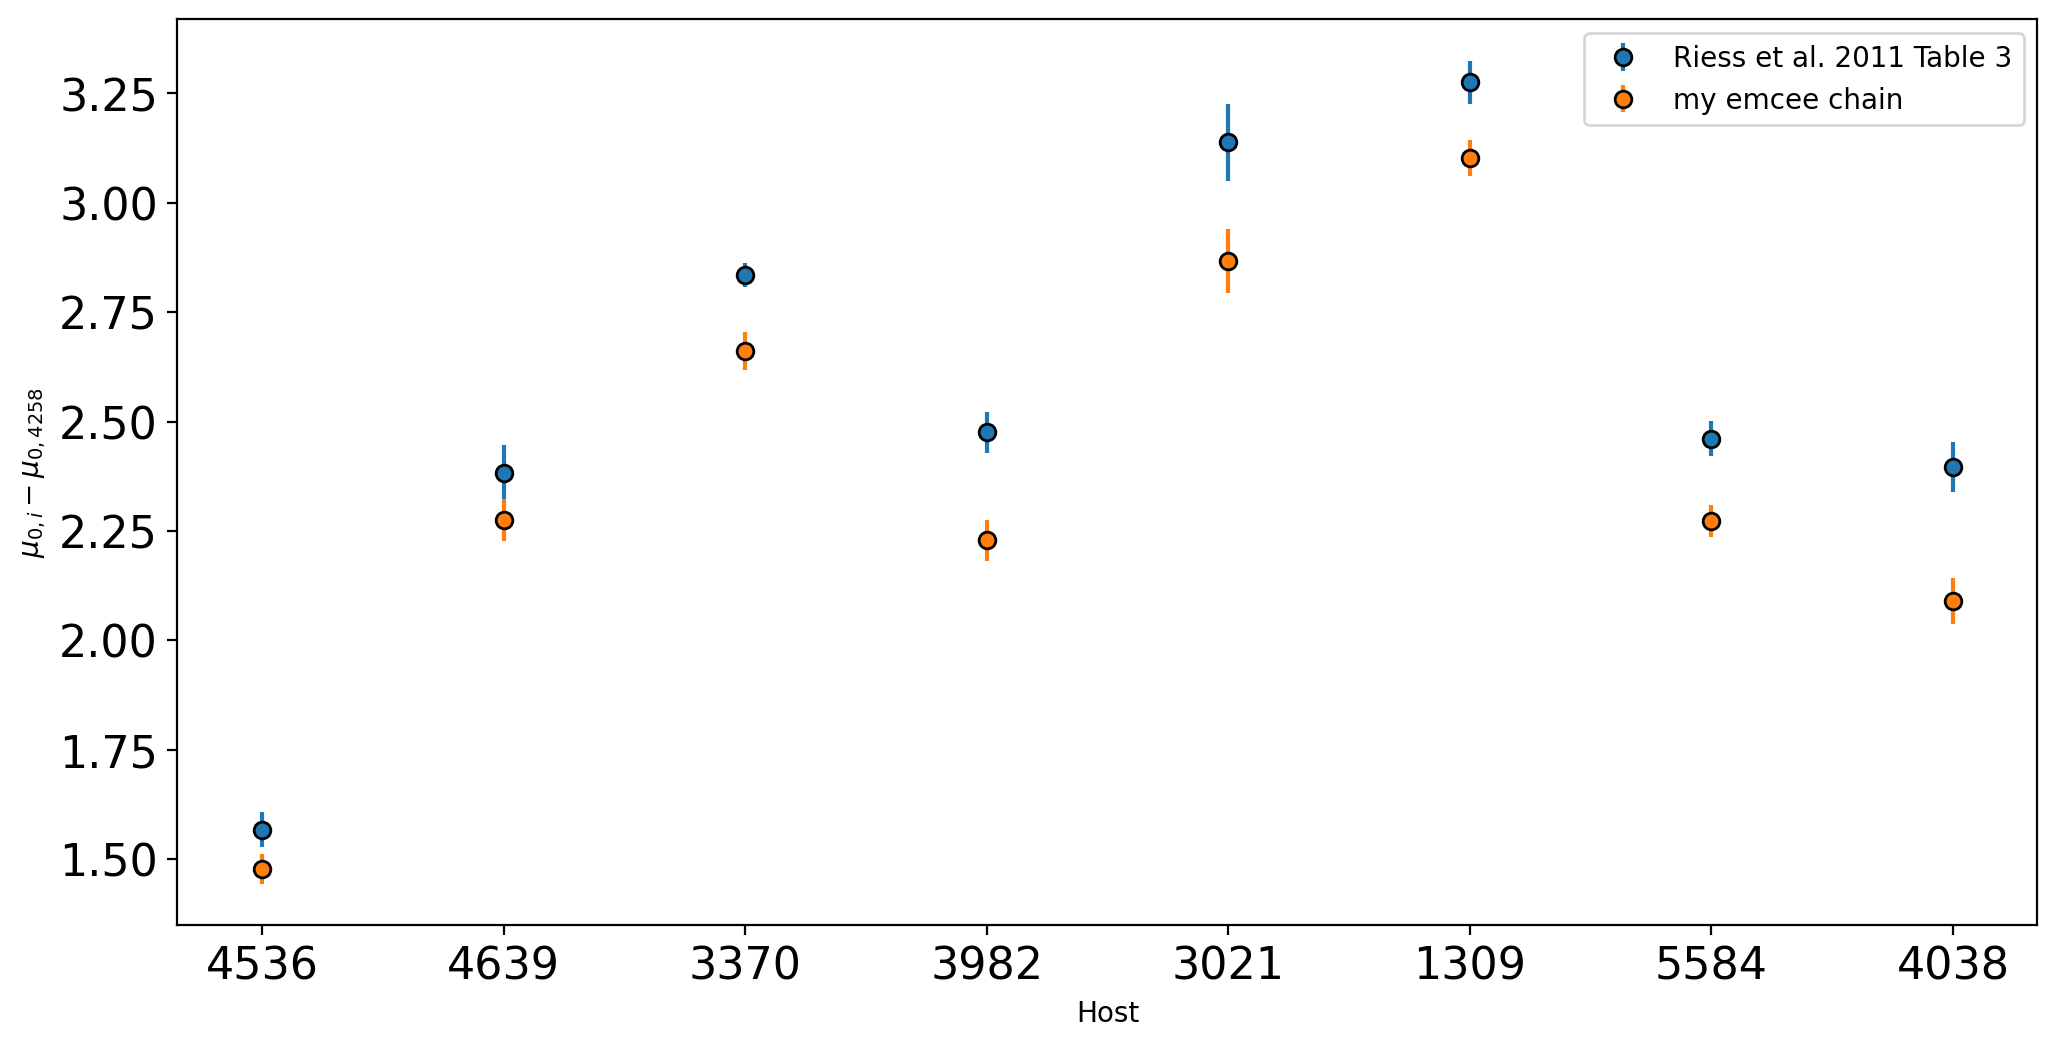

In [30]:
plt.figure(figsize=(12, 6), dpi=200)
plt.errorbar(x=[h[1:] for h in table3['Host']],y=table3_mu_minus_mu,
            yerr=table3_mu_minus_mu_sigma,fmt='o',mec='k',label='Riess et al. 2011 Table 3')

get_uncertainties = np.ones((len(hosts)-1, 100))

for host_enum, host in enumerate(hosts[hosts != '4258']):
    for test_enum, test in enumerate(np.random.randint(0, len(thinned_chain), size=100)):
        get_uncertainties[host_enum, test_enum] = thinned_chain[test,host_enum+1]

mu_std = np.std(get_uncertainties,axis=1)
        
plt.errorbar(x=hosts[hosts != '4258'],y=np.median(thinned_chain, axis=0)[1:],
            yerr=mu_std,fmt='o',mec='k',label='my emcee chain')

plt.xlabel('Host')
plt.ylabel(r'$\mu_{0, i}- \mu_{0, 4258}$')
plt.legend()

The median $\mu_{0, i} - \mu_{0, 4258}$ I measure in the thinned chain are systematically lower than those reported in Table 3. In fact, the measurements are several $\sigma$ away from each other (I use 100 random draws from the chain to estimate uncertainty in the chain in this case). This is sensible, given that I do not perform outlier rejection, whereas Riess et al. 2011 do perform outlier rejection.

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

Riess et al. Equation 3 is
\begin{equation}
m^0_{v, i} = \left(\mu_{0, i} - \mu_{0, 4258} \right) + m^0_{v, 4258}
\end{equation}
for $m^0_{v, i}$ "the maximum-light apparent V-band brightness of an SN Ia in the $i$th host at the time of B-band peak corrected to the fiducial color and luminosity."

Riess et al. Equation 4 is
\begin{equation}
\log H_0 = \frac{\left(m^0_{v, 4258} - \mu_{0, 4258} \right) + 5a_v + 25}{5}
\end{equation}
for $\mu_{4258, 0}$ "obtained through VLBI observations of water megamasers orbiting its central supermassive black hole" and $a_v$ "the intercept of the SN Ia magnitude-redshift relation"



Therefore, the Hubble constant measured using the $i$th host is:

\begin{equation}
\log H_0^i = \frac{m_{v, i}^0 + 5a_v - \mu_{0, i} + 25}{5}
\end{equation}

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [45]:
table3 = Table.read('Riess_table3.dat',format='ascii.csv',
                    names=['Host', 'SN_Ia', 'Filters', 'm0vi+5av', 'sigma', 'mu0i-mu04258', 'mu0Best'],
                   delimiter=' ',comment='#',data_start=0)

In [46]:
mu_minus_mu4258_dict = {}
count = 1
for h in hosts:
    if h != '4258':
        mu_minus_mu4258_dict[h] = np.median(thinned_chain, axis=0)[count]
        count += 1
        
H0s = []
for enum_h, h in enumerate(table3['Host']):
    m0vi_plus_5av = table3['m0vi+5av'][enum_h]
    #h[1:] is just trimming the 'n' off of the host name
    mv0_4258_plus_5av = m0vi_plus_5av - mu_minus_mu4258_dict[h[1:]]
    mu0_4258 = 5.*np.log10(7.6e6)-5 # from Humphreys et al. 2013
    logH0 = (mv0_4258_plus_5av - mu0_4258 + 25.)/5.
    H0s += [10**logH0]

I make random draws from the chain to get a measure of uncertainty on $H_0$ for each host $i$:

In [47]:
std_of_H0_for_each_host = []
count = 1
for enum_h, h in enumerate(table3['Host']):
    current_host_H0s = []
    for rand_draw in np.random.randint(0, len(thinned_chain), size=100):
        if h != '4258':
            mu_minus_mu4258_current = thinned_chain[rand_draw][count]
            m0vi_plus_5av = table3['m0vi+5av'][enum_h]
            mv0_4258_plus_5av = m0vi_plus_5av - mu_minus_mu4258_current
            mu0_4258 = 5.*np.log10(7.6e6)-5
            logH0 = (mv0_4258_plus_5av - mu0_4258 + 25.)/5.
            current_host_H0s += [10**logH0]
    std_of_H0_for_each_host += [np.std(current_host_H0s)]
    count += 1

In [48]:
print(np.mean(H0s), np.sqrt(np.sum(np.array(std_of_H0_for_each_host)**2)))

75.60341853492625 4.96996201313542


For each galaxy, I compute $H_0^i$ using the median of the chain for the parameters. I then estimate uncertainty on this measurement by taking the standard deviation of measured $H_0^i$ for 100 random draws from the chain. 
### I find $H_0 = 75.603 \pm 4.94 \text{km s}^{-1} \text{Mpc}^{-1}$. 

Riess et al. 2011 find $H_0 = 74.8 \pm 3.0 \text{km s}^{-1} \text{Mpc}^{-1}$

Text(0.5, 0, '$H_0$ [km s$^{-1}$ Mpc$^{-1}$]')

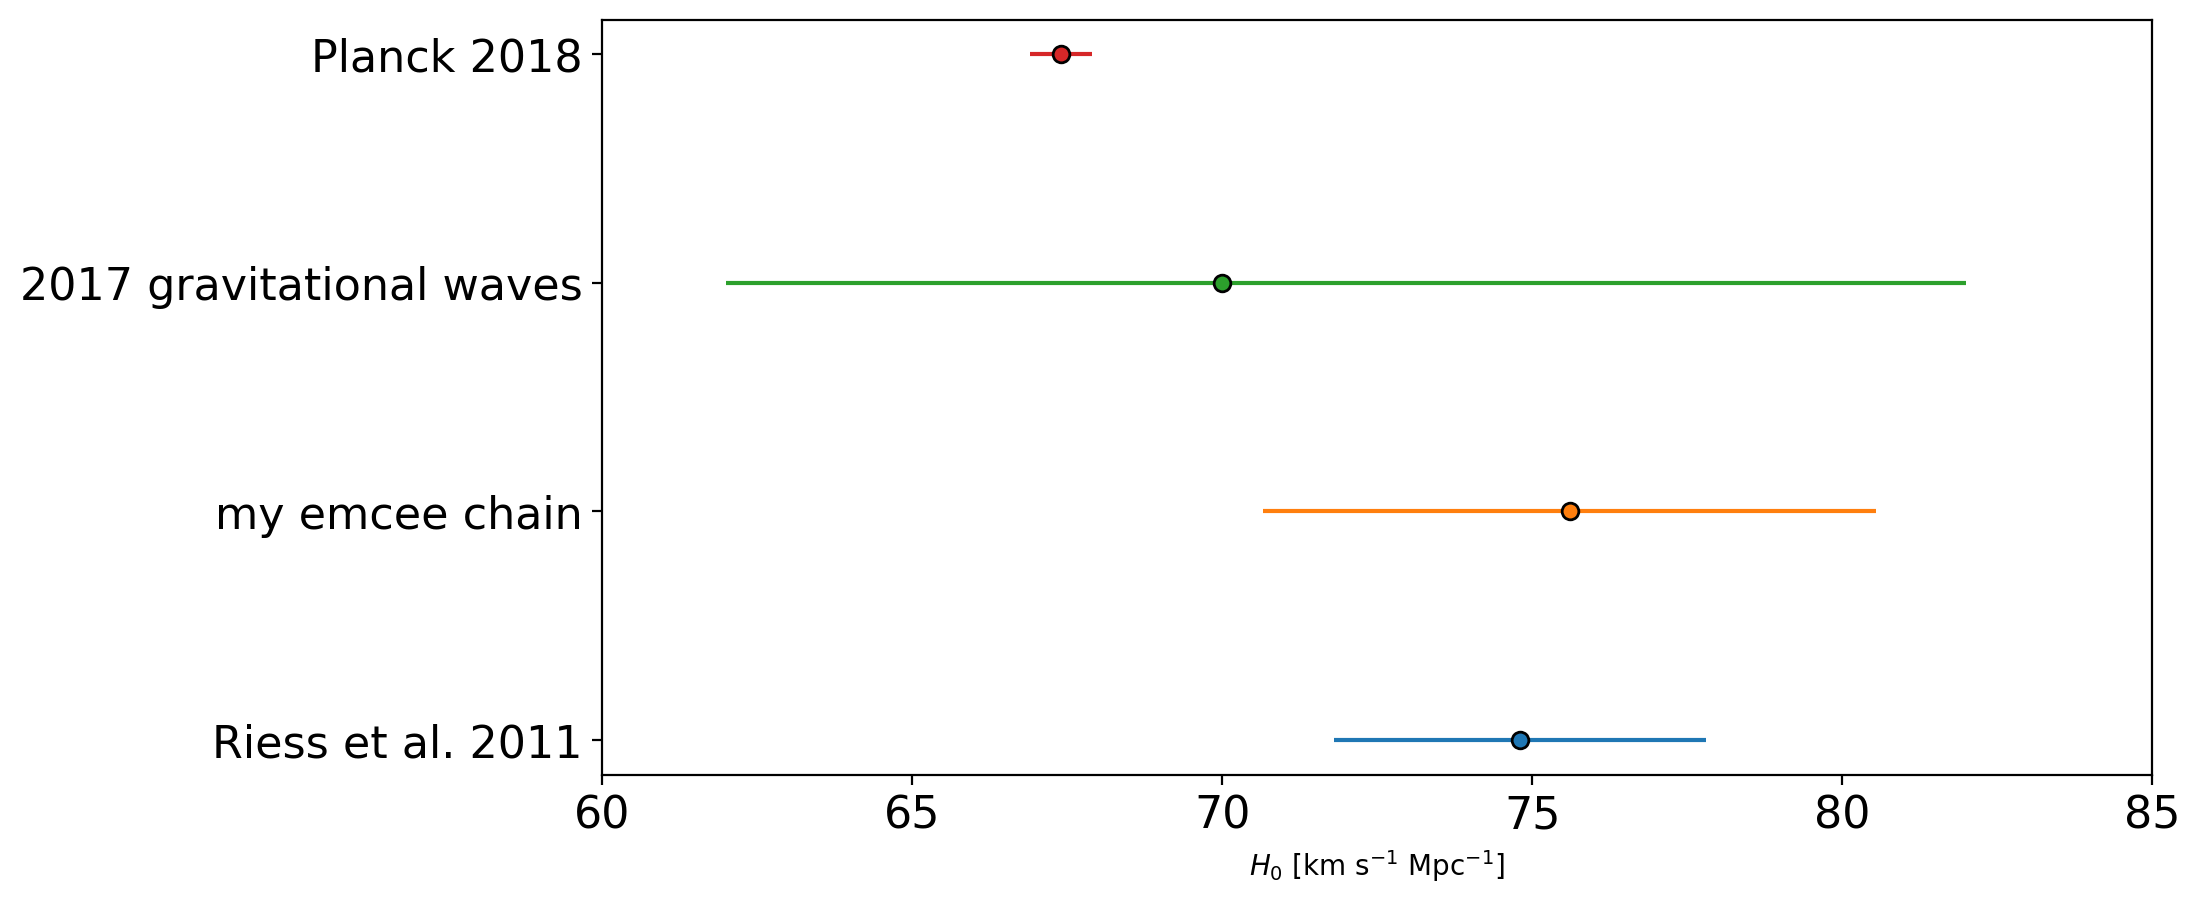

In [49]:
plt.figure(figsize=(10, 5), dpi=200)
plt.errorbar(y=[r'Riess et al. 2011'],x=74.8,xerr=3.0,fmt='o',mec='k')
plt.errorbar(y=[r'my emcee chain'],x=75.603,xerr=4.94,fmt='o',mec='k')
plt.errorbar(y=[r'2017 gravitational waves'],x=np.array([70,]),xerr=np.array([[8, 12]]).T,fmt='o',mec='k')
plt.errorbar(y=[r'Planck 2018'],x=67.4, xerr=0.5,fmt='o',mec='k')
plt.xlim(60, 85)
plt.xlabel(r'$H_0$ [km s$^{-1}$ Mpc$^{-1}$]')